# Multivariate linear binary classification.

## What is linear classification?

**Linear classification** is the task of finding a linear function that best separates a series of differently classified points in euclidean space. The linear function is called a **linear separator**. Each point can be interpreted as an **example**, and each dimension can be interpreted as a **feature**. If the space has 2 dimensions, the linear regression is **univariate** and the linear separator is a **straight line**. If the space has more than 2 dimensions, the linear regression is **multivariate** and the linear separator is a **hyperplane**. If the linear classification classifies examples into two different classes, the classification is **binary**. 

## Linear classification vs. linear regression.

Linear classification and linear regression are similar in their approach and data
representation. However, they solve two different problems. **Linear regression**is the task of finding a linear function that *best approximates* a series of points. The example classification is nothing more than another dimension to a linear regressor. In contrast, a linear classifier treats the example classification not as a dimension, but in a special way that the following code demonstrates.

## Implementing and using linear classification.

As a first step, we import `os.path` to locate our dataset, `pandas` to manipulate the dataset as tabular data, `numpy` to efficiently process our data arrays and `matplotlib.pyplot` to display the results of the linear classification in a graph. We disable warnings to keep the output tidy.

In [1]:
from os import path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Problem statement: Classify Titanic passengers.

The following code uses linear classification to classify the survival of passengers of the ship Titanic. The input data is taken from the [Kaggle Titanic](https://www.kaggle.com/c/titanic) competition.

#### Reading the input data.

In [2]:
datadir = path.abspath(path.expanduser('~/datasets/titanic'))
rawexamples = pd.read_csv(path.join(datadir, 'train.csv'))

In [3]:
rawexamples.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(rawexamples)

891

Our input data `rawexamples` consists of 891 rows. Each row consists of 11 columns that contain information about a passenger. We interpret each row as an *example* and each column as a *feature*. The feature *Survived* classifies each example as either *survived* (1) or *died* (0) and is thus a binary classification. 

#### Cleaning the input data.

Our input data has many features of seemingly low importance. To simplify and speed up the binary classifier, we limit our examples to the three seemingly most important features: *Pclass* (the passenger's class), *Sex* and *Age*.

In [5]:
examples = rawexamples[['Pclass', 'Sex', 'Age']]
examples.head()

,Pclass,Sex,Age
0,3,male,22.0
1,1,female,38.0
2,3,female,26.0
3,1,female,35.0
4,3,male,35.0


Next, we assign a neutral value to all missing values in the input data.

In [6]:
examples = examples.fillna(0)

Additionally, we convert the `Sex` feature to a numerical scale, because our linear classifier takes only numerical input.

In [7]:
examples['Sex'] = examples['Sex'].map({'male': 0, 'female': 1})

 Then, we obtain the classifications.

In [8]:
classifications = rawexamples[['Survived']]

Finally, we split our examples into a training set and a validation set and convert them to arrays.

In [9]:
training_examples = examples.values[:800]
training_classifications = classifications.values[:800]

validation_examples = examples.values[801:]
validation_classifications = classifications.values[801:]

#### Implementing the linear classifier.

In [10]:
class LinearBinaryClassifier:
    def __init__(self, features):
        self.weights = np.zeros(features)
        self.time = 0
    def train(self, examples, classifications):
        for example, classification in zip(examples, classifications):
            self.time += 1
            prediction = self.classify(example)
            for idx, value in enumerate(example):
                weight = self.weights[idx]
                annealing = 1000/(1000 + self.time*10)  # Values chosen by experience.
                self.weights[idx] += annealing * (classification - prediction) * value
    def classify(self, example):
        if np.dot(example, self.weights) > 0:
            return 1
        else:
            return 0

The above linear binary classifier supports two actions, `train()` and `classify()`. `train()` takes a list of examples and their classifications. It then approximates a linear function $$classify(example) = w_1 example_1 + w_2 example_2 + ... + w_n example_n$$ where $example_n$ refers to the value of $example$ for the n-th feature. $\textbf{w}$ is a vector of weights that defines the function $classify$. The output of $classify$ is interpreted in this way:
* value less than 0: classify as 0.
* value greater than 0 : classify as 1.
* value equal to 0: undefined (the algorithm is "uncertain").

The approximation is done by iterating over all examples and updating the weights if an example is misclassified. Specifically, each weight is increased or decreased so that the numerical output of `classify` gets closer to the the correct output range. 

To ensure that the algorithm converges at an approximately optimal solution, we use [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) to gradually lower the learning rate.

#### Using the linear classifier.

To test and use our linear classifier, we need to train it on the example set and than validate it with the validation set. The validation step tells us the accuracy of the linear classifier.

Since our example set has only 800 examples and is thus small for machine learning standards, we will train our linear classifier multiple times with the same examples. After each training iteration, we test our classifier by classifying all examples from the validation set and comparing the output with the expected result. It is important for the validation step that *no* data of the validation data is used for improving the classifier, since this would invalidate subsequent accuracy reports. 

In [11]:
classifier = LinearBinaryClassifier(features = len(training_examples[0]))
training_iterations = 100
accuracy = np.zeros(training_iterations)
for i in range(0,training_iterations):
    classifier.train(training_examples, training_classifications)
    correct = 0
    for example, classification in zip(validation_examples, validation_classifications):
        prediction = classifier.classify(example)
        correct += 1 if prediction == classification else 0
    accuracy[i] = correct/len(validation_examples)

Finally, we plot the reported accuracy of our linear classifier after each iteration.

Text(0.5,0,'Iterations')

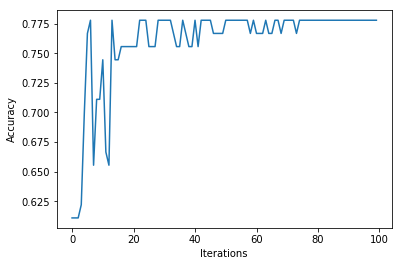

In [12]:
plt.plot(accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Iterations")

The graph shows that our linear classifier has an accuracy of $≈78\%$. This means that when asked to predict the odds of survival of a Titanic passenger, it is correct $≈78\%$ of the time.